# NYSE FANG+ index 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = 'NYFANG'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [4]:
# 日足で過去 2 年分のデータを取得
df0 = ticker.history(period='2y', interval='1d')
 
# ローソク足のチャートには、そのうち過去 1 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_1y =  datetime.timedelta(days=365)
df = df0[df0.index >= dt_last - tdelta_1y]

## Moving Median

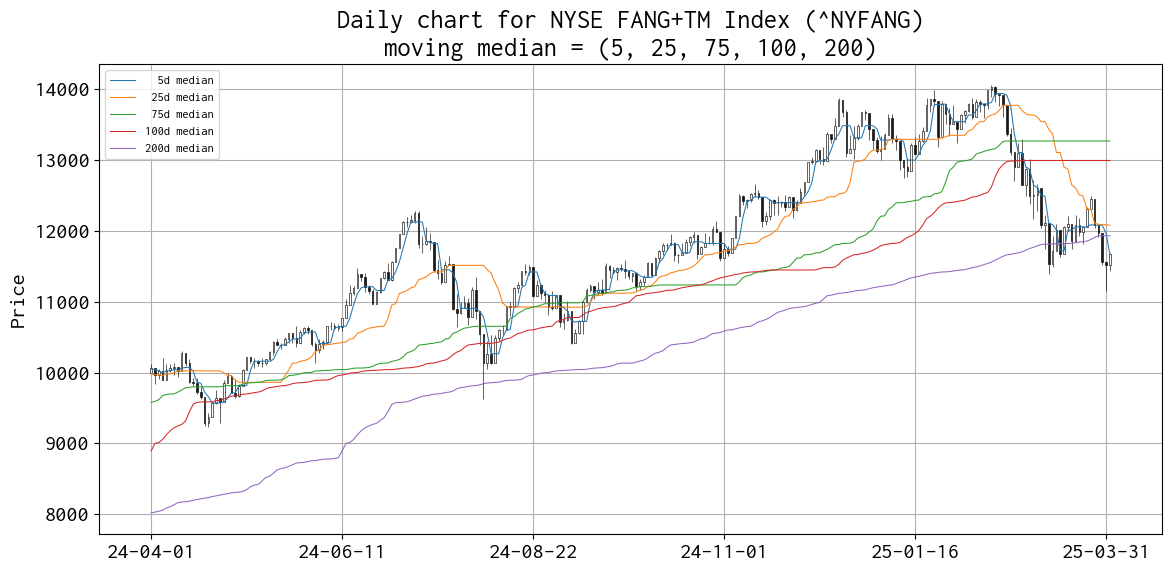

In [5]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax),
]   

mpf.plot(df, type='candle', style='default', datetime_format='%y-%m-%d', addplot=apds, xrotation=0, ax=ax)

ax.set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [6]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-31 00:00:00-04:00,11566.830078,11566.830078,11150.389648,11523.969727,0,0.0,0.0
2025-04-01 00:00:00-04:00,11524.000000,11688.585938,11428.601562,11668.763672,0,0.0,0.0


In [7]:
df.tail(2)['Close']

Date
2025-03-31 00:00:00-04:00    11523.969727
2025-04-01 00:00:00-04:00    11668.763672
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-03-31 00:00:00-04:00           NaN
2025-04-01 00:00:00-04:00    144.793945
Name: Close, dtype: float64

In [9]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-04-01 00:00:00-04:00    144.763672
dtype: float64

In [10]:
df['Close'].rolling(9).median().tail()

Date
2025-03-26 00:00:00-04:00    12079.509766
2025-03-27 00:00:00-04:00    12079.509766
2025-03-28 00:00:00-04:00    12055.480469
2025-03-31 00:00:00-04:00    12055.480469
2025-04-01 00:00:00-04:00    11990.900391
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(13).median().tail()

Date
2025-03-26 00:00:00-04:00    12055.480469
2025-03-27 00:00:00-04:00    12055.480469
2025-03-28 00:00:00-04:00    12055.480469
2025-03-31 00:00:00-04:00    12055.480469
2025-04-01 00:00:00-04:00    12055.480469
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(26).median().tail()

Date
2025-03-26 00:00:00-04:00    12208.729980
2025-03-27 00:00:00-04:00    12100.880371
2025-03-28 00:00:00-04:00    12089.790039
2025-03-31 00:00:00-04:00    12086.699707
2025-04-01 00:00:00-04:00    12082.719727
Name: Close, dtype: float64

In [13]:
df['Close'].rolling(52).median().tail()

Date
2025-03-26 00:00:00-04:00    13105.719727
2025-03-27 00:00:00-04:00    13105.719727
2025-03-28 00:00:00-04:00    13105.719727
2025-03-31 00:00:00-04:00    13105.719727
2025-04-01 00:00:00-04:00    13094.449707
Name: Close, dtype: float64

## Robust Bollinger's bands

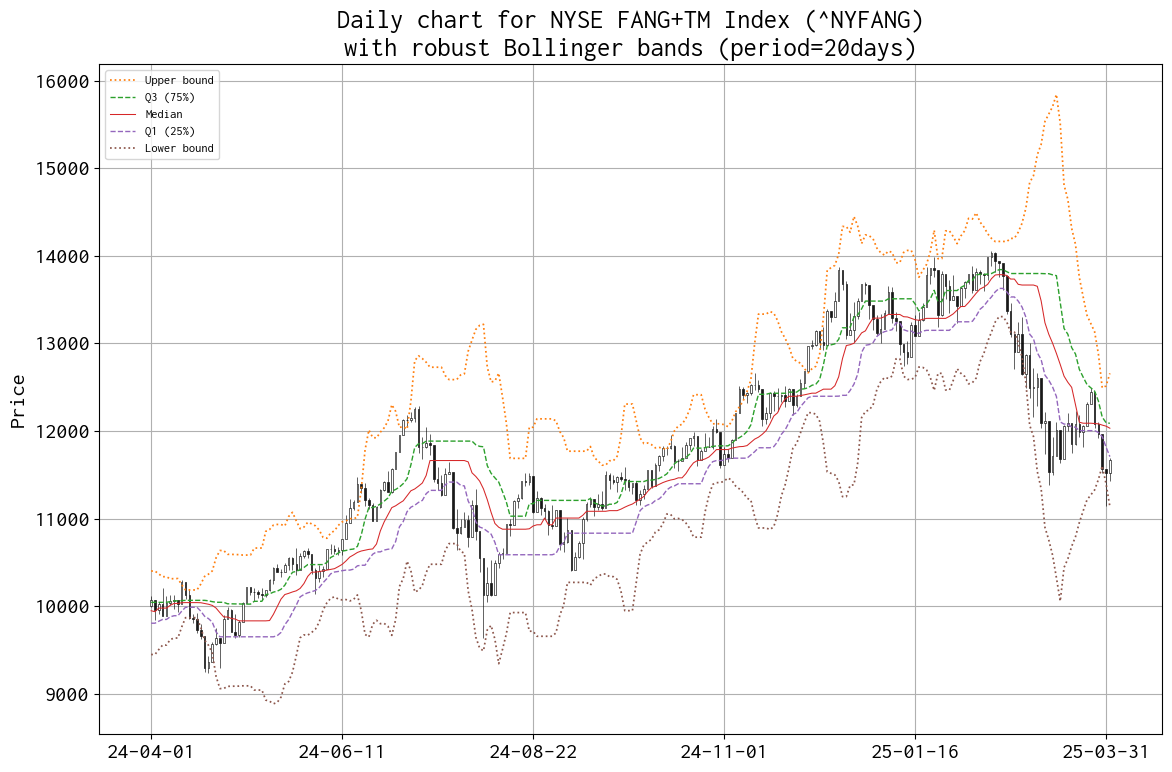

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%ddays)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%ddays)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム & Q-Q プロット

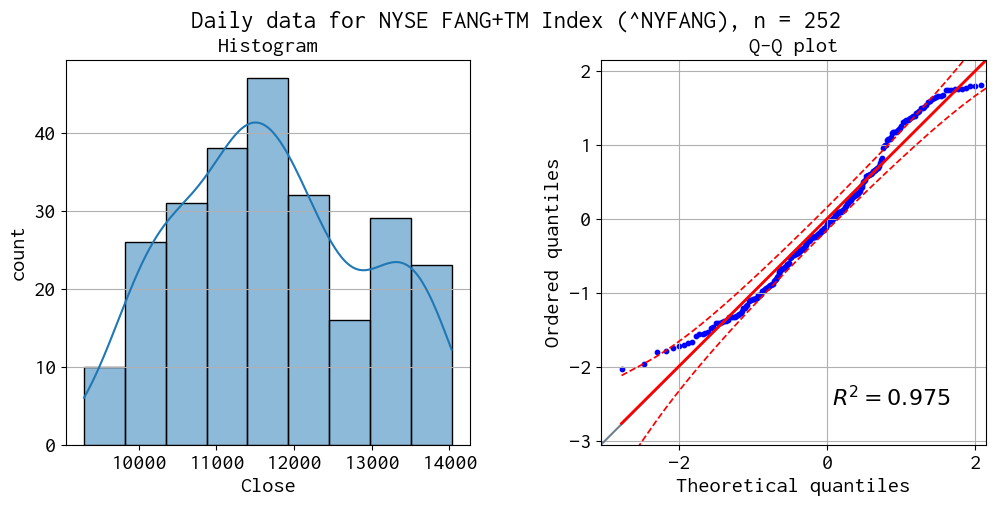

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()